# Coursework 2: Generative Models

#### Instructions

Please submit on CATe a zip file named *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question.
2. Your trained models as *VAE_model.pth, DCGAN_model_D.pth, DCGAN_model_G.pth*

#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 27th February, 2020**

### Setting up working environment

For this coursework you, will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [2]:
!pip install torch torchvision

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1 (50 points)
1. For the first part, you are asked to implement a Variational Autoencoder on the MNIST dataset. You will be assesed by the following:
    - **loss function and proper explanations**. You will have to choose the right loss function by properly modelling the probability distribution of the input pixels. There are more than one accepted approaches. 
    - **reconstruction error**. You will need to achieve a low enough error in order to reconstruct the images of the dataset with relatively high fidelity. You will have to provide us with your best model's training and test loss curves (both the total loss and each individual term), a few reconstructed images and a few sampled images from the latent space of the VAE in the respective cells.
    - **qualitative results**. You have to provide us with certain qualitative results that are usually used to assess the quality of the learned representations (more info below)

 
## Part 2 (50 points)
2. For the DCGAN, The success of your models will be tested as follows:
    - **By the model's training error**. You will need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. You will have to provide us with your best model's training losses curves, a discussion on how you concluded to the chosen architecture, and visualizations of generated samples in the respective cells. Your results do not have to be perfect, however a good discussion on the choice of architecture will be valued.
    - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. You will need to make a discussion on whether you noticed mode collapse or not during your experimentation and if yes, how you addressed it.

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture. You are free to choose either Multilayer Perceptrons (MLPs) or Convolutional Layers

You will need to define:
*  The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward

b. Design an appropriate loss function. There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training.


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib


def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(1)

if not os.path.exists('./CW_VAE/MNIST'):
    os.makedirs('./CW_VAE/MNIST')


cuda:0


In [4]:
# # Directory for saving reconstructions + models
# dir_path = '/content/drive/My Drive/Documents/Imperial/Deep_Learning/CW/cw_2/'

# try:
#     print(os.listdir(dir_path))
# except:
#     from google.colab import drive
#     drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Hyper-parameter selection

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs, the learning rate and the batch size
num_epochs = 40
learning_rate = 1e-3 
batch_size = 32
### Choose a value for the size of the latent space
latent_dim = 20

###

# Define here the any extra hyperparameters you used.

epochs_per_eval = 1     # How frequently should evaluation be conducted
beta = 1                # Weighting on KL divergence in loss function

###

# Modify this line if you need to do any input transformations (optional).
transform = transforms.Compose([
     transforms.ToTensor(),
])

# Modify the denorm function in case you need to do any output transformation when visualizing your images

denorm = lambda x:x

# denorm = lambda x: (0.5)*(x+1).clamp(0,1).view(x.size(0), 1, 28, 28)
# def denorm_for_tanh(x):
#     x = 0.5 * (x + 1)
#     x = x.clamp(0, 1)
#     x = x.view(x.size(0), 1, 28, 28)
#     return x


## Data loading


In [0]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]

save_image(fixed_input, './CW_VAE/MNIST/image_original.png')


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
torch.Size([32, 1, 28, 28])


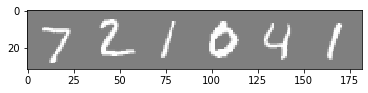

    7     2     1     0     4     1

Each image is of size: torch.Size([1, 28, 28])


In [6]:
# train_dat = datasets.MNIST(
#     "data/", train=True, download=True, transform=transform
# )
# test_dat = datasets.MNIST("data/", train=False, transform=transform)

# loader_train = DataLoader(train_dat, batch_size, shuffle=True)
# loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# sample_inputs, labels = next(iter(loader_test))
# fixed_input = sample_inputs[:32, :, :, :]

# save_image(fixed_input, dir_path + 'recons/image_original.png')

# print(sample_inputs.shape)

# classes = list(range(10))

# # functions to show an image
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # show images
# imshow(make_grid(fixed_input[:6]))
# # print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(6)))
# print()
# print(f'Each image is of size: {fixed_input[0].shape}')

## Model Definition

In [7]:
# *CODE FOR PART 1.1a IN THIS CELL*


class VAE(nn.Module):
    def __init__(self, img_dim=28*28, latent_dim=latent_dim, enc_shape=100, dec_shape=100):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.img_dim = img_dim

        # Encoder architecture
        self.enc_layers = nn.ModuleList([nn.Linear(img_dim, enc_shape, bias=True),
                                        nn.Linear(enc_shape, latent_dim, bias=True),
                                        nn.Linear(enc_shape, latent_dim, bias=True),
                                        ])
        
        # Decoder architecture
        self.dec_layers = nn.ModuleList([nn.Linear(latent_dim, dec_shape, bias=True),
                                        nn.Linear(dec_shape, img_dim, bias=True),
                                        ])
        # self.dec_output = torch.tanh
        self.dec_output = torch.sigmoid

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        x = self.enc_layers[0](x.view(-1, self.img_dim))
        x = F.relu(x)
        mu = self.enc_layers[-2](x)
        logvar = self.enc_layers[-1](x)

        return mu, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        std = torch.exp(0.5*logvar)
        z = torch.randn(std.shape, device=device)

        return z * std + mu

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

        
    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        z = self.dec_layers[0](z)
        z = F.relu(z)
        z = self.dec_layers[-1](z)
        preds = self.dec_output(z)

        return preds

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        preds = self.decode(z)

        return preds, mu, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
model = VAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters is: {params}")
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 163824
VAE(
  (enc_layers): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=20, bias=True)
    (2): Linear(in_features=100, out_features=20, bias=True)
  )
  (dec_layers): ModuleList(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=784, bias=True)
  )
)


## Training loop

In [0]:
# *CODE FOR PART 1.1b IN THIS CELL*
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


def loss_function_VAE(imgs_recon, imgs_orig, mu, logvar):
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    imgs_recon = imgs_recon.view(-1, 28*28)
    imgs_orig = imgs_orig.view(-1, 28*28)

    KL_div = -0.5 * (torch.ones_like(mu) + logvar - mu**2 - logvar.exp()).sum()
    recon_loglik = 0.5 * (imgs_orig - imgs_recon.view(imgs_orig.shape)).norm()**2
    # recon_loglik = F.binary_cross_entropy(imgs_recon.clamp(0.0001, 0.9999), imgs_orig.clamp(0.0001, 0.9999), reduction='sum')

    # Take avg per sample in batch
    KL_div /= imgs_recon.shape[0]
    recon_loglik /= imgs_recon.shape[0]

    return recon_loglik, KL_div

    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 


def evaluate(model, beta):
    test_loss = recon_loglik_test = KL_div_test = 0
    n_batches = len(loader_test)
    with torch.no_grad():   
        for batch in loader_test:
            # Test loop setup
            imgs, _ = batch
            imgs = imgs.view(imgs.shape[0], -1).to(device)

            # Compute forward pass
            imgs_reconstructed, mu, logvar = model(imgs)
            recon_loglik, KL_div = loss_function_VAE(imgs_reconstructed, imgs, mu, logvar)
            loss = recon_loglik + beta * KL_div

            # Accumulate losses
            recon_loglik_test += recon_loglik.item() / n_batches
            KL_div_test += KL_div.item() / n_batches
            test_loss += loss.item() / n_batches

            # print(test_loss)
            # print(recon_loglik_test)
            # print(beta * KL_div_test)

            # assert test_loss - (recon_loglik_test + beta * KL_div_test) < 1e-6, "Values dont sum"

    return test_loss, recon_loglik, KL_div


# Lists for storing various losses
losses = {
    'losses_train': [],
    'recon_losses_train': [],
    'KLDs_train' : [],
    'losses_test' : [],
    'recon_losses_test' : [],
    'KLDs_test' : [],
}

model.train()
for epoch in range(num_epochs):  
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    train_loss = recon_loglik_train = KL_div_train = 0
    n_batches = len(loader_train)
    for batch_idx, batch in enumerate(loader_train):
        
        # Training loop setup
        imgs, _ = batch
        imgs = imgs.view(imgs.shape[0], -1).to(device)
        optimizer.zero_grad()
        
        # Compute forward pass
        imgs_reconstructed, mu, logvar = model(imgs)
        recon_loglik, KL_div = loss_function_VAE(imgs_reconstructed, imgs, mu, logvar)
        loss = recon_loglik + beta * KL_div

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate losses
        recon_loglik_train += recon_loglik.item() / n_batches
        KL_div_train += KL_div.item() / n_batches
        train_loss += loss.item() / n_batches

        # assert train_loss - (KL_div_train + beta * recon_loglik_train) < 1e-6, "Values dont sum"

    # Evaluate on test set
    test_loss, recon_loglik_test, KL_div_test = evaluate(model, beta)
    losses['losses_test'].append(test_loss)
    losses['recon_losses_test'].append(recon_loglik_test)
    losses['KLDs_test'].append(KL_div_test)

    # print out losses and save reconstructions for every epoch
    print(f'epoch [{epoch + 1}/{num_epochs}]   |   train loss : {train_loss:.3f}   |   test loss : {test_loss:.3f}')
    recon = model(fixed_input.to(device))[0]
    recon = denorm(recon.view(fixed_input.shape).cpu())
    save_image(recon, f'./CW_VAE/MNIST/reconstructed_epoch_{epoch}.png')

    # Save losses
    losses['losses_train'].append(train_loss)
    losses['recon_losses_train'].append(recon_loglik_train)
    losses['KLDs_train'].append(KL_div_train)

    # print(losses_train, losses_test)
    # print(recon_losses_train, recon_losses_test)
    # print(KLDs_train, KLDs_test)

    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 

# save the model 
# torch.save(model.state_dict(), dir_path + 'models/VAE_model.pth')
# save the model 
torch.save(model.state_dict(), './CW_VAE/MNIST/VAE_model.pth')

In [27]:
# # Load saved model
# model = VAE().to(device)

# state_dict = torch.load(
#     dir_path + 'models/VAE_model.pth',
#     map_location=lambda storage, loc: storage.cuda(device),
# )
# model.load_state_dict(state_dict)

# # get some random training images
# data_iter = iter(loader_train)
# images, labels = data_iter.next()
# images = images.to(device)
# labels = labels.to(device)
# print(images.shape, labels.shape)

# preds, mu, logvar = model(images)

torch.Size([32, 1, 28, 28]) torch.Size([32])


### Your explanations about the loss function here:
 
- `recon_loglik` is the reconstruction log likelihood. This captures how well the image is recontructed by computing the similarity in intensities between the original and reconstructed image. I experimented with using Binary Cross entropy and mean squared error for this term. BCE loss works here as each pixel intensity ranges between 0 and 1 (and I used sigmoid activation function in the decoder), so BCE measures the differences in pixel intesities summed over all pixels. However, in the end I went with MSE because it produced better results.

- `KL_div` is the KL divergence of the latent space distribution from the prior. This term penalises the network if the distribution of the latent space deviates from the prior distribution. This encourages the network to produce latent space distributions similar to that of the prior. The reason for this is to allow sampling from the latent space so the model can operate as a generative model. The prior in this case is a Gaussian, therefore when we want to generate new samples, we can generate noise in the latent space from a Gaussian distribution. This can be fed through the decoder and should produce high-quality images. If we did not have this KL divergence term, the model would operate as an autoencoder and seek to recontruct the images with as high quality as possible, but we would not be able to generate new images.

- `Beta` is a scalar that determines the relative weighting on KL divergence vs reconstruction log likelihood. Experimentation indicated that `beta=1` was optimal for reconstruction quality.


## Part 1.2 (10 points)

a. Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). 

b. Provide a brief analysis of your loss curves. What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)? Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? If yes, how did you mitigate it? How did this phenomenon reflect on your output samples?

c. Visualize a subset of the images of the test set and their reconstructions as well as a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation) .Please deliver the notebook including the outputs of the cells below.


In [0]:
# import pickle

# # # Save loss curves
# # lst = [losses_train, recon_losses_train, KLDs_train,losses_test, recon_losses_test, KLDs_test]
# # lst_names = ['losses_train', 'recon_losses_train', 'KLDs_train', 'losses_test', 'recon_losses_test', 'KLDs_test']
# # for l,l_n in zip(lst, lst_names):
# #     with open(f'{dir_path}losses/VAE/model2/{l_n}.data', 'wb') as f:
# #         pickle.dump(l, f)

# # Load saved loss curves
# lst_names = ['losses_train', 'recon_losses_train', 'KLDs_train', 'losses_test', 'recon_losses_test', 'KLDs_test']
# losses = {}
# for l_n in lst_names:
#     with open(f'{dir_path}losses/VAE/{l_n}.data', 'rb') as f:
#         l = pickle.load(f)
#         losses[l_n] = l

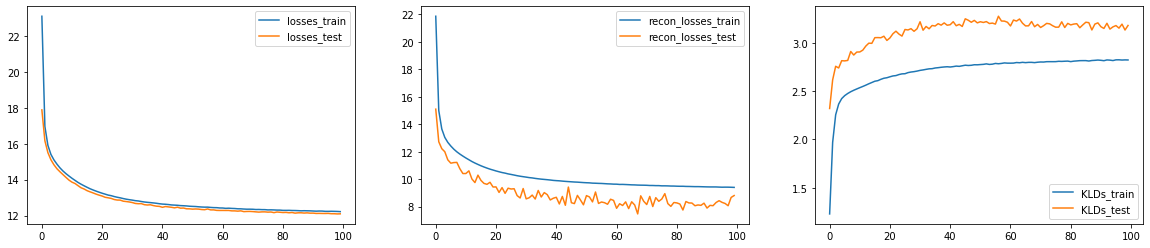

In [29]:
# *CODE FOR PART 1.2a IN THIS CELL*
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
ax1.plot(losses['losses_train'], label='losses_train')
ax1.plot(losses['losses_test'], label='losses_test')
ax1.legend()

ax2.plot(losses['recon_losses_train'], label='recon_losses_train')
ax2.plot(losses['recon_losses_test'], label='recon_losses_test')
ax2.legend()

ax3.plot([k*beta for k in losses['KLDs_train']], label='KLDs_train')
ax3.plot([k*beta for k in losses['KLDs_test']], label='KLDs_test')
ax3.legend()

fig.show()

### Your answer to 1.2b here:

In the above loss curves, we see that total loss falls throughout training, initially rapidly but slows to a steady decline after approx epoch 15. This can analyzed further by breaking loss down into reconstuction loss (middle graph) and KL divergence loss multiplied by `beta` (right-most graph). The reconstruction loss 2-3 times larger than the KL divergence loss (once they are both stabilized) so the overall pattern of the total loss is driven mainly by the reconstruction loss.

While the reconstuction loss falls throughout training, the KL divergence loss increases. This is expected as, while the model trains, it tries to better reproduce the training images. This could be done be separating samples in the latent space by class (i.e. the cluster of images representing number 7 would be a long way away from the cluster of images representing number 0 in the latent space). However, doing this would mean that the distribution in the latent space diverges from the prior of the latent space, and this is not ideal as we use the prior as a way to generate new images by producing sampling latent codes from this prior. Therefore, the loss function of the autoencoder balances learning to reconstuct the images as well as possible (by minimising the reconstruction error) with keeping the latent distribution close to the prior distribution (so we can sample from the prior to generate new images). This explains why the KL divergence initially rises while the reconstuction loss falls.

Posterior collapse is the when the model emphasises fitting the prior in the latent space above reconstucting the images. This means that the network does not create high quality reconstructions irrespective of the latent space input. There is no evidence of posterior collapse in my network as the reconstructions are clear and reflect the original images. In addition, the reconstruction loss declines throughout training, indicating that the reconstuctions are improving throughout training hence indicates posterior collapse has not occured.

torch.Size([256, 20])


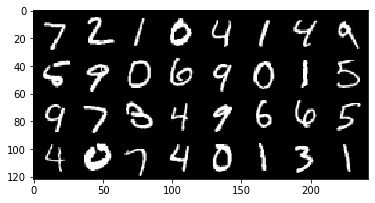

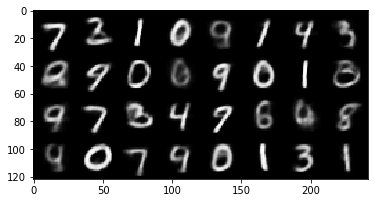

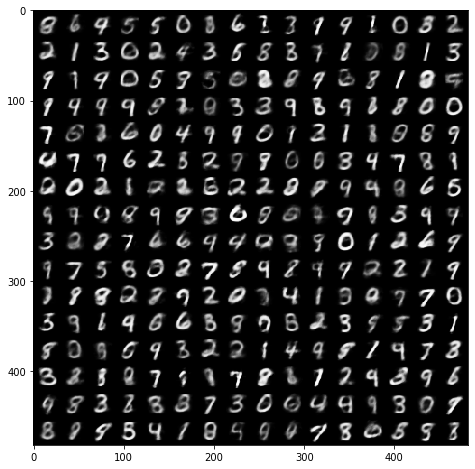

In [9]:
# *CODE FOR PART 1.2c IN THIS CELL*
# model = VAE().to(device)

# state_dict = torch.load(
#     dir_path + 'models/VAE_model.pth',
#     map_location=lambda storage, loc: storage.cuda(device),
# )
# model.load_state_dict(state_dict)

# load the model
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch = model(fixed_input.to(device))[0]
    recon_batch = recon_batch.view(fixed_input.shape)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)
    
model.eval()
n_samples = 256
z = torch.randn(n_samples, latent_dim).to(device)
print(z.shape)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z.to(device))
    samples = samples.view((n_samples,) + fixed_input.shape[1:])
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)


## Part 1.3 (15 points)

### Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Extract the latent representations of the test set and visualize them using T-SNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or PCA. What do you observe? Discuss the structure of the visualized representations. Please use different colours for each digit class.

b. Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from one digit to the other?

In [10]:
# *CODE FOR PART 1.3a IN THIS CELL*
from sklearn.manifold import TSNE

# Extract latent features of test set
with torch.no_grad():
    sample_labels, latent_features = [],[]
    for batch in loader_test:
        # Test loop setup
        imgs, labels = batch
        imgs = imgs.view(imgs.shape[0], -1).to(device)

        # Extract latent features
        mu, logvar = model.encode(imgs)

        std = torch.exp(0.5*logvar)
        z = torch.rand(std.shape, device=device)
        sample = z * std + mu

        latent_features.append(sample)
        sample_labels.append(labels)


latent_features = torch.cat(latent_features).cpu()
sample_labels = torch.cat(sample_labels).cpu()
print(latent_features.shape, sample_labels.shape)

# Perform TSNE
X_embedded = TSNE(n_components=2).fit_transform(latent_features)

print(X_embedded.shape)

torch.Size([10000, 20]) torch.Size([10000])
(10000, 2)


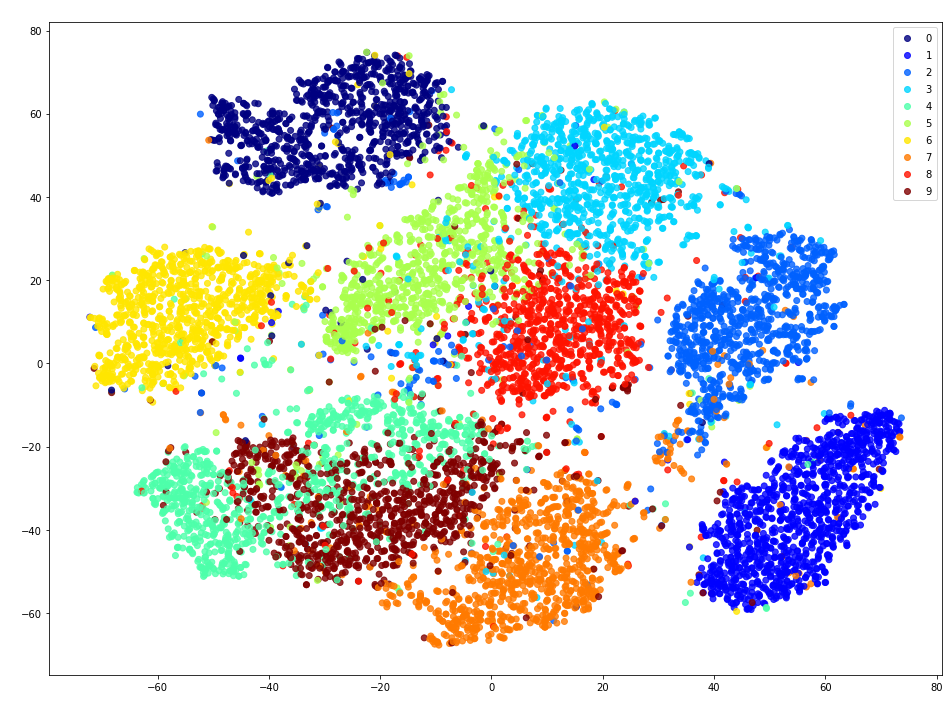

In [11]:
# Plot t-SNE
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

x,y = np.hsplit(X_embedded, 2)
fig = plt.figure(figsize=(16,12))
scatter = plt.scatter(np.squeeze(x), np.squeeze(y), c=np.squeeze(sample_labels.numpy()), cmap=cmap, alpha=0.8)
plt.legend(*scatter.legend_elements())
plt.xlabel('Dimension 1', c='w')
plt.ylabel('Dimension 2', c='w')
plt.title('Visualisation of t-SNE projection of VAE latent features', c='w')

plt.show()

### Your answer to 1.3a here:

The t-SNE visualization above shows the following:

- The latent codes for the digits are separated into individual clusters in the latent space 2-d representation. This is expected as images representing the same digit should have similar characteristics and therefore should appear close to one another in the t-SNE visualisation.

- Digits that look more similar to one another are located closer to one another in the latent space (i.e. the cluster of sixes is close to the cluster of zeros and the cluster of ones is close to the cluster of sevens). This makes sense as similar-looking digits should have similar features therefore should have lower euclidian distance in the Z-space, thus look closer to one-another in the t-SNE visualization above.

- Clusters for some digits are not well defined and overlap in some cases. This is the case for fours and nines. This means that the model struggles to distingush fours and nines and this is represented by the reconstructed images of fours and nines looking similar to one another.

- There are some gaps between some of the clusters (i.e. around the cluster of ones). These gaps are related to the value of alpha: the higher alpha is, the smaller gaps are and the more classes overlap.

torch.Size([10000, 20])


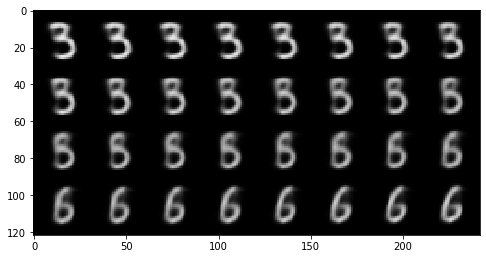

In [19]:
# *CODE FOR PART 1.3b IN THIS CELL*
print(latent_features.shape)
# Choose 2 digits
dig_1, dig_2 = 3, 6
sample_1 = latent_features[torch.where(sample_labels==dig_2)[0][3]]
sample_2 = latent_features[torch.where(sample_labels==dig_1)[0][2]]

# Create samples using linear interpolation on latent space
n = 32
samples = [alpha/(n-1) * sample_1 + (1-alpha/(n-1)) * sample_2 for alpha in range(n)]
sample_tensors = torch.tensor(np.vstack(samples)).to(device)

# Decode samples
with torch.no_grad():
    sample_imgs = model.decode(sample_tensors)
    sample_imgs = sample_imgs.view(fixed_input.shape)

    sample_imgs = sample_imgs.cpu()
    samples = make_grid(denorm(sample_imgs), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)


### Your answer to 1.3b here:

As shown in the figure above, performing an interpolation between two digits (3 and 6 in this case) leads to the decoded images transitioning between the two digits. When we are closer to 3, the digits look closer to 3 than 6, and as we move in the direction of 6, they become more 6-like. The images in the middle of the interpolation actually start resembling a five, although they are blurred in appearance. This suggests that the Z-codes of the interpolated start becoming similar to the Z-codes of fives in the middle of the interpolation. This hypothesis is backed up by the t-SNE visualization, as the cluster of fives is in-between the clusters of threes and sixes. Therefore it seems logical that as the digit transitions from three to six it starts to resemble a five at some point.

## Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse. 

_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get full marks. The attached model does not have to be perfect._

### Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

b. visualize images sampled from your best model's generator.

c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

For b. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(123)

if not os.path.exists('./CW_DCGAN'):
    os.makedirs('./CW_DCGAN')

cuda:0


In [0]:
# # Directory for saving reconstructions + models
# dir_path = '/content/drive/My Drive/Documents/Imperial/Deep_Learning/CW/cw_2/'

# try:
#     print(os.listdir(dir_path))
# except:
#     from google.colab import drive
#     drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data loading

In [0]:
batch_size = batch_size_ = 32
NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.ColorJitter(),
])


data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


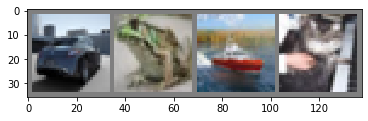

  car  frog  ship   cat

Each image is of size: torch.Size([3, 32, 32])


In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img/2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
data_iter = iter(loader_train)
images, labels = data_iter.next()

# show images
imshow(make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
print()
print(f'Each image is of size: {images[0].shape}')

### Hyper-parameter selection

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*

### Choose the number of epochs, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 50
learning_rate = 1e-4
latent_vector_size = 20
###

# Define here other hyperparameters that you used.

channels = (1024, 512, 256, 128, 3)     # Defines the number of channels for each (transpose) conv layer. The channels for each layer in the discriminator are this list in reverse order...


In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*

class Generator(nn.Module):
    def __init__(self, channels=channels):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        c1, c2, c3, c4, c5 = channels
        self.model = nn.Sequential(
            # Conv 1
            nn.ConvTranspose2d(in_channels=latent_vector_size, out_channels=c1, kernel_size=3),
            nn.BatchNorm2d(num_features=c1),
            nn.ReLU(True),
            # Conv 2
            nn.ConvTranspose2d(in_channels=c1, out_channels=c2, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=c2),
            nn.ReLU(True),
            # Conv 3
            nn.ConvTranspose2d(in_channels=c2, out_channels=c3, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=c3),
            nn.ReLU(True),
            # Conv 4
            nn.ConvTranspose2d(in_channels=c3, out_channels=c4, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=c4),
            nn.ReLU(True),
            # Conv 5
            nn.ConvTranspose2d(in_channels=c4, out_channels=c5, kernel_size=2),
            # Output
            nn.Tanh()

        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        z = z.to(device)
        x = self.model(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return x

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self, channels=channels[::-1]):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        c1, c2, c3, c4, c5 = channels
        self.model = nn.Sequential(
            # Conv 1
            nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=3),
            nn.BatchNorm2d(num_features=c2),
            nn.LeakyReLU(0.2, inplace=True),
            # Conv 2
            nn.Conv2d(in_channels=c2, out_channels=c3, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=c3),
            nn.LeakyReLU(0.2, inplace=True),
            # Conv 3
            nn.Conv2d(in_channels=c3, out_channels=c4, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=c4),
            nn.LeakyReLU(0.2, inplace=True),
            # Conv 4
            nn.Conv2d(in_channels=c4, out_channels=c5, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=c5),
            nn.LeakyReLU(0.2, inplace=True),
            # Conv 5
            nn.Conv2d(in_channels=c5, out_channels=1, kernel_size=2),         
            # Output
            nn.Sigmoid()   
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = x.to(device)
        out = self.model(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out

    def forward(self, x):
        out = self.discriminator(x)
        return out.view(-1, 1).squeeze(1)

# g = Generator().to(device)
# d = Discriminator().to(device)

# with torch.no_grad():
#     z = torch.randn((16, latent_vector_size, 1, 1))
#     print(z.shape)
#     img_gen = g(z).cpu()
#     print(img_gen.shape)

#     imshow(make_grid(img_gen, nrow=4, padding=2))

#     preds = d(img_gen)
#     print(preds.shape)


### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 6384771
Generator(
  (model): Sequential(
    (0): ConvTranspose2d(20, 1024, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(2, 2), stride=(1, 1))
    (13): Tanh()
  )
)


Total number of parameters in Discriminator is: 6206465
Discrimi

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))
# Schedulers
# schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=1, gamma=0.9, last_epoch=-1)
# schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=1, gamma=0.9, last_epoch=-1)

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size_, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [0]:
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    for i, data in enumerate(loader_train, 0):
        train_loss_D = 0
        train_loss_G = 0
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), './CW_DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(), './CW_DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
            
# save losses and models
torch.save(model_G.state_dict(), './CW_DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW_DCGAN/DCGAN_model_D.pth')


# train_losses_G = []
# train_losses_D = []

# GPU = True
# if GPU:
#     device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
# else:
#     device = torch.device("cpu")

# for epoch in range(num_epochs+1):
#     train_loss_D_batch = 0
#     train_loss_G_batch = 0
#     for i, data in enumerate(loader_train, 0):
#         train_loss_D = 0
#         train_loss_G = 0
        
#         ########################################################
#         # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#         ########################################################
#         # train with real
#         model_D.zero_grad()
#         real_cpu = data[0].to(device)
#         batch_size = real_cpu.size(0)
#         label = torch.full((batch_size,), real_label, device=device)

#         output = model_D(real_cpu)
#         errD_real = loss_function(output, label)
#         errD_real.backward()
#         D_x = output.mean().item()

#         # train with fake
#         noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
#         fake = model_G(noise)
#         label.fill_(fake_label)
#         output = model_D(fake.detach())
#         errD_fake = loss_function(output, label)
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()
#         errD = errD_real + errD_fake
#         train_loss_D += errD.item()
#         optimizerD.step()
#         # schedulerD.step()

#         ########################################################
#         # (2) Update G network: maximize log(D(G(z)))
#         ########################################################
#         model_G.zero_grad()
#         label.fill_(real_label)  # fake labels are real for generator cost
#         output = model_D(fake)
#         errG = loss_function(output, label)
#         errG.backward()
#         D_G_z2 = output.mean().item()
#         train_loss_G += errG.item()
#         optimizerG.step()
#         # schedulerG.step()

#         train_loss_D_batch += train_loss_D
#         train_loss_G_batch += train_loss_G

#         if i % 50 == 0:
#             print(f'[{epoch:02}/{num_epochs}][{i:04}/{len(loader_train)}] | Loss_D: {errD.item():.3f} |' +
#                   f' Loss_G: {errG.item():.3f} | D(x): {D_x:.3f} | D(G(z)): {D_G_z1:.3f} / {D_G_z2:.3f}')

#     if epoch == 0:
#         save_image(denorm(real_cpu.cpu()).float(), dir_path + 'cifar_recons/real_samples.png')
    
#     fake = model_G(fixed_noise)
#     save_image(denorm(fake.cpu()).float(), dir_path + 'cifar_recons/fake_samples_epoch_%03d.png' % epoch)
#     b_loss_D = train_loss_D_batch / len(loader_train) / batch_size_
#     b_loss_G = train_loss_G_batch / len(loader_train) / batch_size_
#     print(f'\n Batch Loss_D: {b_loss_D:.3f} | Batch Loss_G: {b_loss_G:.3f} \n')
#     train_losses_D.append(b_loss_D)
#     train_losses_G.append(b_loss_G)

#     if epoch > 0 and epoch % 10 == 0:
#         lst = [train_losses_D, train_losses_G]
#         lst_names = ['train_losses_D', 'train_losses_G']
#         for l, l_n in zip(lst, lst_names):
#             with open(dir_path + f'losses/DCGAN/{l_n}.data', 'wb') as f:
#                 pickle.dump(l, f)

#         # save losses and models
#         torch.save(model_G.state_dict(), dir_path + 'models/DCGAN_model_G.pth')
#         torch.save(model_D.state_dict(), dir_path + 'models/DCGAN_model_D.pth')

[00/50][0000/1532] | Loss_D: 1.688 | Loss_G: 2.298 | D(x): 0.482 | D(G(z)): 0.535 / 0.114
[00/50][0050/1532] | Loss_D: 1.098 | Loss_G: 6.398 | D(x): 0.776 | D(G(z)): 0.497 / 0.003
[00/50][0100/1532] | Loss_D: 1.189 | Loss_G: 6.555 | D(x): 0.633 | D(G(z)): 0.347 / 0.002
[00/50][0150/1532] | Loss_D: 0.631 | Loss_G: 7.176 | D(x): 0.853 | D(G(z)): 0.342 / 0.002
[00/50][0200/1532] | Loss_D: 0.446 | Loss_G: 6.248 | D(x): 0.799 | D(G(z)): 0.145 / 0.003
[00/50][0250/1532] | Loss_D: 0.284 | Loss_G: 6.036 | D(x): 0.893 | D(G(z)): 0.149 / 0.004
[00/50][0300/1532] | Loss_D: 0.244 | Loss_G: 5.820 | D(x): 0.888 | D(G(z)): 0.106 / 0.004
[00/50][0350/1532] | Loss_D: 0.378 | Loss_G: 5.098 | D(x): 0.834 | D(G(z)): 0.146 / 0.008
[00/50][0400/1532] | Loss_D: 0.371 | Loss_G: 4.961 | D(x): 0.832 | D(G(z)): 0.154 / 0.009
[00/50][0450/1532] | Loss_D: 0.189 | Loss_G: 4.360 | D(x): 0.935 | D(G(z)): 0.110 / 0.017
[00/50][0500/1532] | Loss_D: 0.153 | Loss_G: 4.552 | D(x): 0.955 | D(G(z)): 0.094 / 0.014
[00/50][05

In [0]:
###DISCUSS THE SELECTION OF THE ARCHITECTURE IN THIS CELL


#FINAL MODEL CHOICE
'''
My final model is shown above in the code. This follows many of the recommendations in the linked 
paper and I have explained my choices below.
- Generator:
    - Only used transpose convolutions. These had the following number of channels: (1024, 512, 256, 128, 3) 
    - ReLU activation
    - Batch norm between layers
    - Tanh output layer

- Discriminator:
    - Only used convolutional layers. These had the following number of channels: (3, 128, 256, 512, 1024, 1)
        - It was convenient to make the dicriminator and generators 'mirrors' of one another by simply
        reversing the channels and this performed well
    - Leaky Relu with 0.2 slope
    - Batch norm between layers
    - Sigmoid output (ensures activations are between 0-1 so allows use of Binary Cross Entropy loss)

Additionally, I used the following hyperparam config:
- num_epochs = 50
    - Training plateaued by then so no point training for longer...
- learning_rate = 1e-4
    - Using a learning scheduler made the output images worse and was more hyperparameters to tune so I decided to use a small learning rate but no scheduler
- latent_vector_size = 20
    - Decreasing the latent vector size made the output images worse but there was no visible benefit to increasing latent_vector_size
'''

# HYPERPARAMETER TUNING / MODEL CONFIGURATION STRATEGY
'''
I decided to manually tune hyperparameters / alter model configuration in this case. This was becuase manual tuning allowed me to get a better 
intuition for which configurations and hyperparameters were more important. In the future, however, guided by this intuition, I would opt for an
automatic method, such as random search. Bayesian optimization would be my normal choice for hyperparameter search but it would not work for 
GANs because of the lack of a clear function to evaluate.
'''

# EXPERIMENTS
'''
To reach the final configuration detailed above, I conducted extensive experimentation. These experiments are detailed below:

### 1:
Setup:
- Generator:
    - Only used transpose convolutions with channels: (256, 128, 3) 
    - ReLU activation
    - No batch norm or dropout
    - Tanh output layer

- Discriminator:
    - Only used convolutional layers with channels: (3, 128, 256, 1)
    - Relu activation
    - No batch norm or dropout
    - Sigmoid output

Summary:
Began producing images after approx epoch 5. These were very low quality and did not resemble any of the CIFAR-10 classes




### 2:
Changes from above:
    - Added 2 layers to the discriminator and generator with channels of 512 and 1024 (the layers resembled the final model in this case)


Summary:
Produced images were much higher quality. Some of the produced images began resembling the CIFAR images and features such as wheels, wings, legs 
began appearing in the output images. I experimented with adding additional layers by the network took too long to train (approx 5 mins per epoch
when it is this size even on the GPU).



### 3:
Changes from above:
    - Added normalization between layers for the generator and discriminator. Experimented with both batch norm or dropout

Summary
Further improved images using batch norm but dropout did not seem to help so I added batch norm to the networks.



### 4:
Changes from above:
    - Experimented with the learning rate (it was originally 1e-3). Also tried adding schedulers:
            schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=1, gamma=0.9, last_epoch=-1)
            schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=1, gamma=0.9, last_epoch=-1)

Summary:
The schedulers did not seem to help and they added hyperparameters to I decided not to use them. Reducing the learning rate did help the network to learn
more during the later training epochs and improved the images so i reduced the learning rate to 1e-4



### 5:
Changes from above:
    - Experimented with the latent space dimension. It was originally 15 but I tried 20, 30 and 50

Summary:
When the latent space was 20 and 30 the images were better than when it was 15. When the latent dim was 50, the network produced only noise. Thus I decided on
latent_dim = 20 as increasing further did not seem helpful.



### 6:
Changes from above:
    - Experimented with some additional transforms
        # transforms.RandomHorizontalFlip(),
        # transforms.ColorJitter(),

Summary:
These did not seem to help and the ColorJitter made the networks produce only noise, therefore I did not proceed with these.




Additionally, I experimented with batch size and Adam parameters (beta1, beta2). At this point, I could not seem to improve the quality of produced images
and I ran out of time so I stopped.
'''

### Generator samples

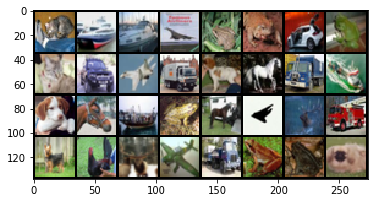

In [0]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

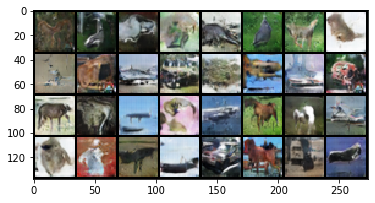

In [0]:
# load the model
model_G.load_state_dict(torch.load('./CW_DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Part 2.2 (10 points)

### Train losses curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

The code for generating the plot is already given. Make sure that the version of the notebook you deliver includes these results.

In [0]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

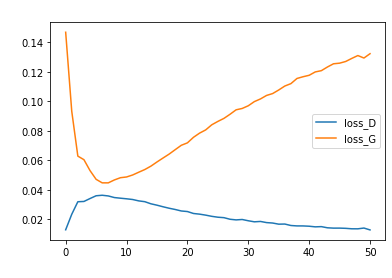

In [0]:
# import matplotlib.pyplot as plt

# with open(dir_path + f'losses/DCGAN/train_losses_D.data', 'rb') as f:
#     train_losses_D = pickle.load(f)

# with open(dir_path + f'losses/DCGAN/train_losses_G.data', 'rb') as f:
#     train_losses_G = pickle.load(f)

# plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
# plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
# plt.legend()
# plt.title('Train Losses', c='w')
# plt.xlabel('Epochs', c='w')
# plt.ylabel('Loss', c='w')
# plt.show()

## ANSWER FOR PART 2.2 IN THIS CELL

As shown above, the loss curves do not behave as anticipated for the generator and discriminator. The expected behaviour is that the discriminator's loss should rise and the genetor's loss fall until both converge on the same value. The losses for my model behave as expected for the first 5 epochs (i.e. discriminator and generator loss converge) but after epoch 5 they diverge for the remainder of training. This indicates that the GAN is not training as expected so we would not expect to see good images produced.

However, the value of the loss does not necessarily correlate with the quality of images produced by the generator. In the cell below I have shown the output of the generator for the fixed sample from epochs 0, 5, 20 and 50. There is a clear improvement from epochs 0 to 5 with shapes and patterns being discernible in epoch 5 compared with noise in epoch zero. Comparing epoch 50 to epoch 5, at least in my opinion, the images again improve in quality and focus. In some images for epoch 50 a class can be clearly made out, for example a car in the bottom-left most image. So while the losses do not behave as expected after epoch 5, the images still improve in quality.

My explanation for the behaviour in losses after epoch 5 is that the discriminator improves at a faster rate than the generator so the discriminator gets more images correct despite the quality of the fake images improving. This is backed up by my epirical results with respect to network architectures: I found that when I added more convolutional layers to the generator (keeping the size of the discriminator fixed), the losses diverged at a slower rate. This leads me to believe that adding even more layers to the generator might improve the quality of the produced images, but I have run out of time to experiment further on this coursework.

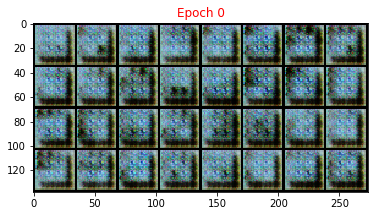

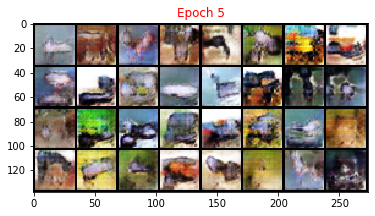

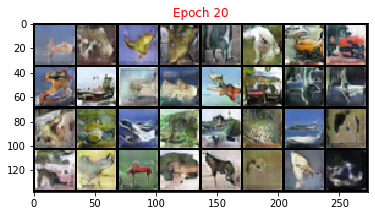

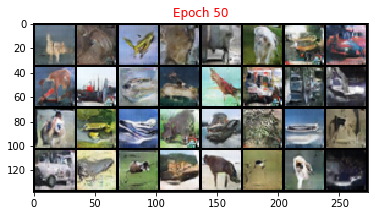

In [0]:
'''PLEASE DO NOT RUN THIS CELL!! THESE IMAGES WILL CHANGE IF YOU DO
AND MY EXPLANATION REFERS TO THESE IMAGES'''

# # ANSWER FOR PART 2.2 IN THIS CELL*
# import matplotlib.image as mpimg
# img_path = dir_path + 'cifar_recons/current_best/fake_samples_epoch_'

# img = mpimg.imread(img_path + '000.png')
# img1 = mpimg.imread(img_path + '005.png')
# img2 = mpimg.imread(img_path + '020.png')
# img3 = mpimg.imread(img_path + '050.png')

# plt.imshow(img)
# plt.title('Epoch 0', c='r')
# plt.show()

# plt.imshow(img1)
# plt.title('Epoch 5', c='r')
# plt.show()

# plt.imshow(img2)
# plt.title('Epoch 20', c='r')
# plt.show()

# plt.imshow(img3)
# plt.title('Epoch 50', c='r')
# plt.show()

### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

In [0]:
# ANSWER FOR PART 2.3 IN THIS CELL*

'''
Mode collapse is when the generator only creates a subset of the classes, and in an extreme
case only creates a single class. This occurs because the objective for the generator is 
to fool the discriminator, so the generator could end up predicting only a single class very
well and fooling the generator. There is nothing in the objective function which incentivises
generating a variety of images. However, the discriminator would then learn likely learn
that the generator only predicts a single class, and therefore it would learn to detect
this single class. This would result in the generator shifting to create only a single different
node, which the discriminator would then learn again in response. This can lead to a cat and mouse
game where the model never converges on an optimal solution where all classes are generated well.

As shown in the above images, mode collapse does not appear to have occured in my GAN. The quality
of the images is not that high so it is difficult to tell if partial collapse has occured, but it 
is clear that the generator is predicting at least several, if not all, the classes to some extent.

Mode collapse can occur if the generator is more powerful than the discriminator, or if it is updated
more frequently during training. Theoretically, if the discriminator was frozen and only the 
generator trained then we would certainly expect mode collapse: the discriminator would converge
on a single point (the point which the discriminator is least able to detect). If the discriminator
and gerator are equally powerful and updated with equal regularity, then at each step the update to 
the discriminator should work to counter the mode collapse by recognizing the mode the generator is 
predicting more frequently and assigning this a lower probability of being a true sample. Therefore,
I conclude that mode collapse did not occur in my model because both my generator and discriminator
are similarly powerful and have similar numbers of parameters.

This view seems to be supported by my loss curves. The loss curves indicate that (after epoch 5),
the discriminator becomes disproportionately better then the generator, hence implying that the
generator is not more powerful than the discriminator. My earlier conculsion was that the quality
of images is limited by the power of the generator and to make higher quality images I should increase
the size of the generator. However, my analysis on mode collapse suggests that this will make mode
collapse more likely. This is a manifestation of the widely-held view that training GANs is a 
difficult process. I would have liked to investiatge these hypotheses further but unfortunately
I have run out of time on this assignment.
'''